## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [55]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from tqdm import tqdm


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [56]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [58]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [59]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [60]:
len(fmnist_dataset_test)

10000

In [61]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [62]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [63]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
              ReLU-3                  [-1, 784]               0
            Linear-4                   [-1, 64]          50,240
       BatchNorm1d-5                   [-1, 64]             128
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
Total params: 52,586
Trainable params: 52,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.20
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


Your experiments come here:

In [64]:
from tqdm import tqdm
model = TinyNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

EPOCHS = 15
best_val_loss = np.inf

for epoch in range(EPOCHS):
  training_loss = 0.0
  model.train()
  for batch, label in tqdm(train_loader):
    opt.zero_grad()
    batch = batch.to(device)
    label = label.to(device)

    pred = model(batch)

    loss = loss_func(pred, label)
    loss.backward()
    opt.step()

    training_loss += loss.item()

  if epoch % 5 == 0:
    valid_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    for batch, label in tqdm(test_loader):
      with torch.no_grad():
        batch = batch.to(device)
        label = label.to(device)
        pred = model(batch)

        for x, target in zip(torch.argmax(pred, axis=1), label):
          if x == target:
              correct += 1
          total += 1
        loss = loss_func(pred, label)
        valid_loss += loss.item()
    valid_loss = valid_loss / len(test_loader)

    print(f"EPOCH {epoch}, TRAIN_LOSS: {training_loss/len(train_loader)}")
    print(f"EPOCH {epoch}, TEST_LOSS: {valid_loss}, TEST_ACC: {correct/total:.5f}")

100%|██████████| 40/40 [00:01<00:00, 31.53it/s]


EPOCH 0, TRAIN_LOSS: 0.6406789640627945
EPOCH 0, TEST_LOSS: 0.4803323298692703, TEST_ACC: 0.83040


100%|██████████| 40/40 [00:01<00:00, 32.04it/s]


EPOCH 5, TRAIN_LOSS: 0.29568473132116707
EPOCH 5, TEST_LOSS: 0.390891245752573, TEST_ACC: 0.86350


100%|██████████| 40/40 [00:01<00:00, 30.55it/s]


EPOCH 10, TRAIN_LOSS: 0.2349471567091403
EPOCH 10, TEST_LOSS: 0.3583280470222235, TEST_ACC: 0.88220


100%|██████████| 469/469 [00:07<00:00, 63.09it/s]


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [66]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [67]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                  [-1, 512]         401,920
              ReLU-4                  [-1, 512]               0
       BatchNorm1d-5                  [-1, 512]           1,024
            Linear-6                   [-1, 64]          32,832
              ReLU-7                   [-1, 64]               0
       BatchNorm1d-8                   [-1, 64]             128
            Linear-9                   [-1, 32]           2,080
             ReLU-10                   [-1, 32]               0
      BatchNorm1d-11                   [-1, 32]              64
           Linear-12                   [-1, 10]             330
Total params: 439,946
Trainable params: 439,946
Non-trainable params: 0
-------------------------------

In [68]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

EPOCHS = 55

best_val_loss = np.inf
train_acc_arr = []
test_acc_arr = []

for epoch in range(EPOCHS):

  model.train()
  training_loss = 0.0
  train_correct = 0
  train_total = 0 

  for batch, label in tqdm(train_loader):

    opt.zero_grad()
    batch = batch.to(device)
    label = label.to(device)
    pred = model(batch)

    loss = loss_func(pred, label)
    loss.backward()
    opt.step()

    if epoch % 5 == 0:

      for x, target in zip(torch.argmax(pred,axis = 1), label): #max score for each again

        if x == target:

          train_correct += 1

        train_total += 1

    training_loss += loss.item()
  
  
  if epoch % 5 == 0:

    train_acc = train_correct/train_total
    train_acc_arr.append(train_acc)
    valid_loss = 0.0
    correct = 0
    total = 0
    model.eval()

    for batch, label in tqdm(test_loader):

      with torch.no_grad():
        batch = batch.to(device)
        label = label.to(device)
        pred = model(batch)

        for x, target in zip(torch.argmax(pred,axis = 1), label):
          if x == target:
              correct += 1
          total += 1
      
        loss = loss_func(pred, label)
        valid_loss += loss.item()
    test_acc = correct/total
    test_acc_arr.append(test_acc)
    valid_loss = valid_loss / len(test_loader)

    print(f"EPOCH {epoch}, TRAIN_LOSS: {training_loss/len(train_loader)}, TRAIN_ACC: {train_acc:.5f}")
    print(f"EPOCH {epoch}, TEST_LOSS: {valid_loss}, TEST_ACC: {test_acc:.5f}")    

 82%|████████▎ | 33/40 [00:01<00:00, 34.10it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7ec6ca59d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 92%|█████████▎| 37/40 [00:01<00:00, 23.80it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7ec6ca59d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/da

EPOCH 0, TRAIN_LOSS: 0.4647446774534071, TRAIN_ACC: 0.83225
EPOCH 0, TEST_LOSS: 0.4245735161006451, TEST_ACC: 0.84550


  6%|▌         | 26/469 [00:00<00:11, 37.04it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7ec6ca59d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  9%|▊         | 41/469 [00:00<00:07, 59.51it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7ec6ca59d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/

EPOCH 5, TRAIN_LOSS: 0.2671354507713684, TRAIN_ACC: 0.90045
EPOCH 5, TEST_LOSS: 0.32585180550813675, TEST_ACC: 0.88250


100%|██████████| 40/40 [00:01<00:00, 31.38it/s]


EPOCH 10, TRAIN_LOSS: 0.23105870694049133, TRAIN_ACC: 0.91292
EPOCH 10, TEST_LOSS: 1.0977072352543473, TEST_ACC: 0.88590


100%|██████████| 40/40 [00:01<00:00, 31.63it/s]


EPOCH 15, TRAIN_LOSS: 0.18328649147169424, TRAIN_ACC: 0.93088
EPOCH 15, TEST_LOSS: 0.6465771943330765, TEST_ACC: 0.88860


100%|██████████| 40/40 [00:01<00:00, 31.43it/s]


EPOCH 20, TRAIN_LOSS: 0.15683738036609407, TRAIN_ACC: 0.94133
EPOCH 20, TEST_LOSS: 3.6564039427787067, TEST_ACC: 0.88450


100%|██████████| 40/40 [00:01<00:00, 30.47it/s]


EPOCH 25, TRAIN_LOSS: 0.1285864019047604, TRAIN_ACC: 0.95155
EPOCH 25, TEST_LOSS: 0.5809105090796948, TEST_ACC: 0.89140


100%|██████████| 40/40 [00:01<00:00, 30.96it/s]


EPOCH 30, TRAIN_LOSS: 0.11114086287378121, TRAIN_ACC: 0.95767
EPOCH 30, TEST_LOSS: 1.2364279676228762, TEST_ACC: 0.89310


100%|██████████| 40/40 [00:01<00:00, 31.50it/s]


EPOCH 35, TRAIN_LOSS: 0.09378612110975074, TRAIN_ACC: 0.96478
EPOCH 35, TEST_LOSS: 0.9430444560945034, TEST_ACC: 0.89150


100%|██████████| 40/40 [00:01<00:00, 31.43it/s]


EPOCH 40, TRAIN_LOSS: 0.08202905521622852, TRAIN_ACC: 0.96913
EPOCH 40, TEST_LOSS: 1.120603683590889, TEST_ACC: 0.89330


100%|██████████| 40/40 [00:01<00:00, 30.68it/s]


EPOCH 45, TRAIN_LOSS: 0.07334653167987365, TRAIN_ACC: 0.97265
EPOCH 45, TEST_LOSS: 0.9332311458885669, TEST_ACC: 0.89550


100%|██████████| 40/40 [00:01<00:00, 31.40it/s]


EPOCH 50, TRAIN_LOSS: 0.064594681305227, TRAIN_ACC: 0.97590
EPOCH 50, TEST_LOSS: 1.3678183630108833, TEST_ACC: 0.89190


100%|██████████| 469/469 [00:07<00:00, 61.20it/s]


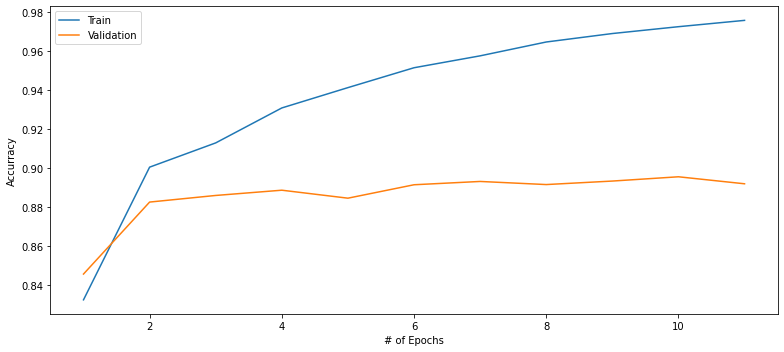

In [69]:
fig = plt.figure(figsize=(11,5))
plt.plot(range(1,len(train_acc_arr)+1), train_acc_arr, label='Train')
plt.plot(range(1,len(test_acc_arr)+1), test_acc_arr, label='Validation')

plt.xlabel('# of Epochs')
plt.ylabel('Accurracy')
plt.legend()
plt.tight_layout()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [70]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):

        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape),
            nn.Dropout1d(0.05),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout1d(0.05),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout1d(0.05),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout1d(0.05),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):       
        out = self.model(inp)
        return out


In [71]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
         Dropout1d-3                  [-1, 784]               0
            Linear-4                  [-1, 512]         401,920
              ReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
         Dropout1d-7                  [-1, 512]               0
            Linear-8                   [-1, 64]          32,832
              ReLU-9                   [-1, 64]               0
      BatchNorm1d-10                   [-1, 64]             128
        Dropout1d-11                   [-1, 64]               0
           Linear-12                   [-1, 32]           2,080
             ReLU-13                   [-1, 32]               0
      BatchNorm1d-14                   

In [72]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

EPOCHS = 55

best_val_loss = np.inf
train_acc_arr = []
test_acc_arr = []

for epoch in range(EPOCHS):

  model.train()
  training_loss = 0.0
  train_correct = 0
  train_total = 0 

  for batch, label in tqdm(train_loader):

    opt.zero_grad()
    batch = batch.to(device)
    label = label.to(device)
    pred = model(batch)

    loss = loss_func(pred, label)
    loss.backward()
    opt.step()

    if epoch % 5 == 0:

      for x, target in zip(torch.argmax(pred,axis = 1), label): #max score for each again

        if x == target:

          train_correct += 1

        train_total += 1

    training_loss += loss.item()
  
  
  if epoch % 5 == 0:

    train_acc = train_correct/train_total
    train_acc_arr.append(train_acc)
    valid_loss = 0.0
    correct = 0
    total = 0
    model.eval()

    for batch, label in tqdm(test_loader):

      with torch.no_grad():
        batch = batch.to(device)
        label = label.to(device)
        pred = model(batch)

        for x, target in zip(torch.argmax(pred,axis = 1), label):
          if x == target:
              correct += 1
          total += 1
      
        loss = loss_func(pred, label)
        valid_loss += loss.item()
    test_acc = correct/total
    test_acc_arr.append(test_acc)
    valid_loss = valid_loss / len(test_loader)

    print(f"EPOCH {epoch}, TRAIN_LOSS: {training_loss/len(train_loader)}, TRAIN_ACC: {train_acc:.5f}")
    print(f"EPOCH {epoch}, TEST_LOSS: {valid_loss}, TEST_ACC: {test_acc:.5f}")    

100%|██████████| 40/40 [00:01<00:00, 31.71it/s]


EPOCH 0, TRAIN_LOSS: 0.8299722475792045, TRAIN_ACC: 0.69135
EPOCH 0, TEST_LOSS: 0.4267018582671881, TEST_ACC: 0.84850


100%|██████████| 40/40 [00:01<00:00, 31.21it/s]


EPOCH 5, TRAIN_LOSS: 0.662358378804823, TRAIN_ACC: 0.74767
EPOCH 5, TEST_LOSS: 0.3392852574586868, TEST_ACC: 0.87510


100%|██████████| 40/40 [00:01<00:00, 31.82it/s]


EPOCH 10, TRAIN_LOSS: 0.6189501004051298, TRAIN_ACC: 0.76335
EPOCH 10, TEST_LOSS: 0.3237745001912117, TEST_ACC: 0.88040


100%|██████████| 40/40 [00:01<00:00, 31.58it/s]


EPOCH 15, TRAIN_LOSS: 0.5838133629196997, TRAIN_ACC: 0.77638
EPOCH 15, TEST_LOSS: 0.3246070017572492, TEST_ACC: 0.89050


100%|██████████| 40/40 [00:01<00:00, 31.97it/s]


EPOCH 20, TRAIN_LOSS: 0.558347599020899, TRAIN_ACC: 0.78588
EPOCH 20, TEST_LOSS: 0.352136486582458, TEST_ACC: 0.88840


100%|██████████| 40/40 [00:01<00:00, 31.29it/s]


EPOCH 25, TRAIN_LOSS: 0.5432970825670116, TRAIN_ACC: 0.79170
EPOCH 25, TEST_LOSS: 0.3283302075229585, TEST_ACC: 0.88800


100%|██████████| 40/40 [00:01<00:00, 31.87it/s]


EPOCH 30, TRAIN_LOSS: 0.5312238958979975, TRAIN_ACC: 0.79705
EPOCH 30, TEST_LOSS: 0.6328180979937315, TEST_ACC: 0.89030


100%|██████████| 40/40 [00:01<00:00, 32.36it/s]


EPOCH 35, TRAIN_LOSS: 0.5183199179261478, TRAIN_ACC: 0.80165
EPOCH 35, TEST_LOSS: 0.529278003424406, TEST_ACC: 0.89270


100%|██████████| 40/40 [00:01<00:00, 32.43it/s]


EPOCH 40, TRAIN_LOSS: 0.5057730168930249, TRAIN_ACC: 0.80605
EPOCH 40, TEST_LOSS: 8.460944811627268, TEST_ACC: 0.89100


100%|██████████| 40/40 [00:01<00:00, 31.68it/s]


EPOCH 45, TRAIN_LOSS: 0.49876563915057476, TRAIN_ACC: 0.80908
EPOCH 45, TEST_LOSS: 5.719187060371041, TEST_ACC: 0.88540


100%|██████████| 40/40 [00:01<00:00, 32.27it/s]


EPOCH 50, TRAIN_LOSS: 0.4961372436617992, TRAIN_ACC: 0.80843
EPOCH 50, TEST_LOSS: 1.0602049658074975, TEST_ACC: 0.89160


100%|██████████| 469/469 [00:07<00:00, 59.52it/s]


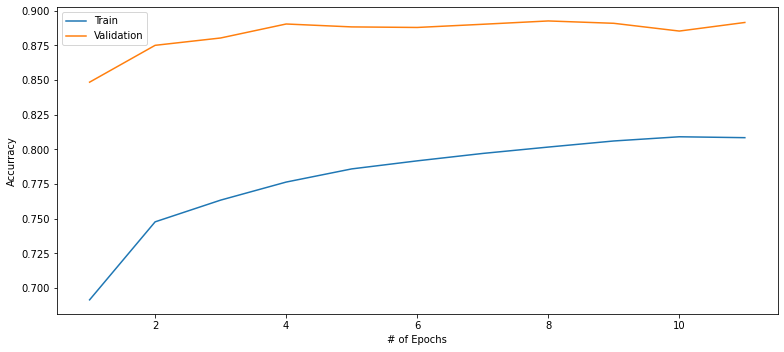

In [73]:
fig = plt.figure(figsize=(11,5))
plt.plot(range(1,len(train_acc_arr)+1), train_acc_arr, label='Train')
plt.plot(range(1,len(test_acc_arr)+1), test_acc_arr, label='Validation')

plt.xlabel('# of Epochs')
plt.ylabel('Accurracy')
plt.legend()
plt.tight_layout()
plt.show()

### Conclusions:
_We got good quality models on a large dataset.
 With the addition of dropouts, batchnorm we did not greatly improve the overfitted model._